# Potential field extrapolation

This notebook shows how to continue a magnetic field from a certain level from a certain level.   Note that here the field is random below that point, while in a real case the field should already be close to potential, to avoud artificial currents at the interface.

We need FFTs and random numbers

In [1]:
import numpy as np
from numpy import fft, random

In [2]:
n=16
b=random.random((3,n,n,n))
(b**2).mean()

0.33963453133695404

Check that the norm is conserved

In [3]:
b2=fft.ifft2(fft.fft2(b))
(b2**2).mean()

(0.33963453133695404+0j)

Get the wavenumbers, corresponding to a box of size 1.

In [4]:
k=fft.fftfreq(n)*n*2*np.pi
k

array([  0.        ,   6.28318531,  12.56637061,  18.84955592,
        25.13274123,  31.41592654,  37.69911184,  43.98229715,
       -50.26548246, -43.98229715, -37.69911184, -31.41592654,
       -25.13274123, -18.84955592, -12.56637061,  -6.28318531])

Set the boundary level to 12

In [6]:
i2_bdry=12
bx=b[0,:,:,:]
by=b[1,:,:,:]
bz=b[2,:,:,:]
bz0=bz[:,:,i2_bdry]
bz0.shape

(16, 16)

The extrapolation is based on the FFT of Bz at the boundary:

In [7]:
bz0_fft=fft.fft2(bz0)

Compute the vertical and horizontal components of the potential field

In [12]:
bx_fft=np.zeros((n,n),dtype=np.complex)
by_fft=np.zeros((n,n),dtype=np.complex)
bz_fft=np.zeros((n,n),dtype=np.complex)
kk=np.zeros((n,n))
dz=1/n
for i2 in range(i2_bdry,n):
    for i1 in range(n):
        k1=k[i1]
        for i0 in range(n):
            k0=k[i0]
            k2=np.sqrt(k0**2+k1**2)
            bz_fft[i0,i1]=bz0_fft[i0,i1]*np.exp(-k2*dz*(i2-i2_bdry))
            if k2>0:
                phi=-bz_fft[i0,i1]/k2
            else:
                phi=0.0
            bx_fft[i0,i1]=1j*k0*phi
            by_fft[i0,i1]=1j*k1*phi
            kk[i0,i1]=k2
            #print(i2,k0,k1,bx_fft[i0,i1])
    bx[:,:,i2]=np.real(fft.ifft2(bx_fft))
    by[:,:,i2]=np.real(fft.ifft2(by_fft))
    bz[:,:,i2]=np.real(fft.ifft2(bz_fft))
    print(i2,bx[:,:,i2].max())

12 0.43968778889096477
13 0.07845772695745062
14 0.027696464673548294
15 0.01182834668111939


Bz(z) become smoother with height, as high-k components are damped out

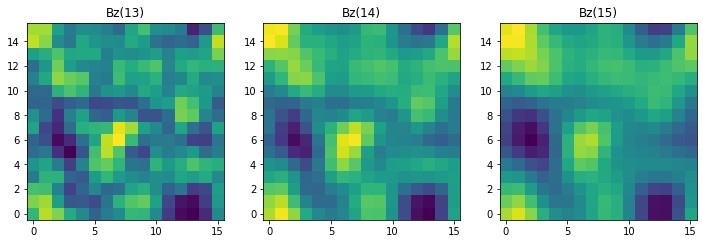

In [11]:
import pylab as pl
pl.figure(figsize=(12,5))
pl.subplot(1,3,1)
pl.imshow(bz[:,:,13].T,origin='lower'); pl.title('Bz(13)');
pl.subplot(1,3,2)
pl.imshow(bz[:,:,14].T,origin='lower'); pl.title('Bz(14)');
pl.subplot(1,3,3)
pl.imshow(bz[:,:,15].T,origin='lower'); pl.title('Bz(15)');

Verify that the signs of Bx and By are correct, relative to decreasing Bz

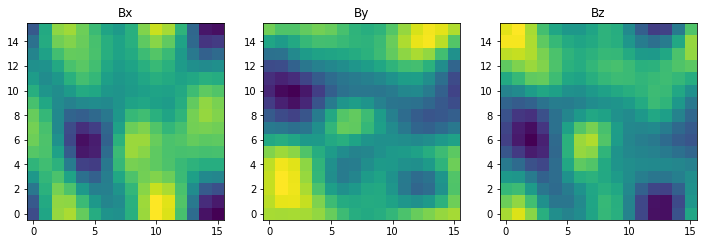

In [10]:
pl.figure(figsize=(12,5))
pl.subplot(1,3,1)
pl.imshow(bx[:,:,15].T,origin='lower'); pl.title('Bx');
pl.subplot(1,3,2)
pl.imshow(by[:,:,15].T,origin='lower'); pl.title('By');
pl.subplot(1,3,3)
pl.imshow(bz[:,:,15].T,origin='lower'); pl.title('Bz');

**NOTE 1**: If derivatives of B are needed, they can of course be obtained from finite differences, but also analytically

**NOTE 2**: If the field is only for use in guard zones it shold be fine as is, but if it is to be made compatible with a numerical div(B)=0 requirement one can leave the horizontal components as they are, and adjust the Bz field to make it exactly div-free